In [2]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate

In [3]:
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import numpy as np
import time

nb.__version__

'0.55.2'

In [5]:
## Infinite double well system
    
def U(x):
    """
    potential of the infinite double well
    """

    return (1/(2*x**2)+x*x)

def pinf(x,tau):
    return np.exp(-U(x)/tau)

def dU(x):
    """
    potential of the double well
    """

    return -(-x**(-3)+2*x)

##--------set the axis 
b=4
x1=np.arange(0.1,b,0.0001)
x2=np.arange(-b,-0.1,0.0001)

## ------- Plot 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,6))# plt.figure(figsize=(4,4))

ax1.plot(x1,U(x1),color="r")
ax1.plot(x2,U(x2),color="r")
ax1.set_xlabel("x")
ax1.set_ylabel("$V(x)$")

ax2.plot(x2,dU(x2),color="r")
ax2.set_ylabel("$ V'(x)$")
ax2.plot(x1,dU(x1),color="r")
ax2.set_xlabel("x")

# plt.legend()
ax3.set_xlabel("x")
ax3.plot(x2,pinf(x2,1),color="r")
ax3.plot(x1,pinf(x1,1),color="r")
ax3.set_ylabel("$\\rho_{\infty}(x)$")
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


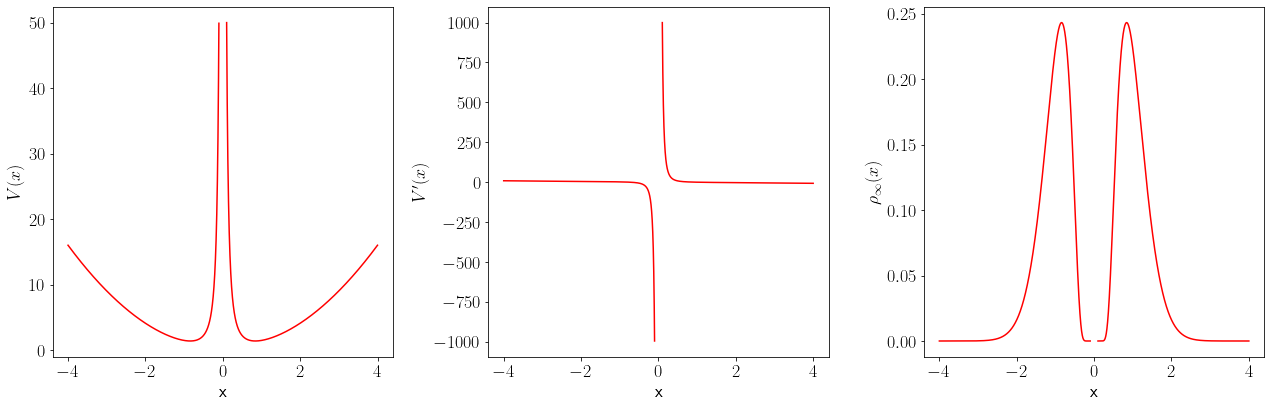

In [8]:
## ------- Plot 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,6))# plt.figure(figsize=(4,4))

ax1.plot(x1,U(x1),color="r")
ax1.plot(x2,U(x2),color="r")
ax1.set_xlabel("x")
ax1.set_ylabel("$V(x)$")

ax2.plot(x2,dU(x2),color="r")
ax2.set_ylabel("$ V'(x)$")
ax2.plot(x1,dU(x1),color="r")
ax2.set_xlabel("x")

# plt.legend()
ax3.set_xlabel("x")
ax3.plot(x2,pinf(x2,1),color="r")
ax3.plot(x1,pinf(x1,1),color="r")
ax3.set_ylabel("$\\rho_{\infty}(x)$")
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

### Generate sample paths from the SDE
$$ dX = - U'(x) dt + \sqrt{2 \tau} dW $$

where $$ U'(x) = -\frac{1}{x^3}+2x $$

Below is a numba code that compute sample path for the SDE stated above using the Euler-Maruyama numerical scheme.

In [8]:

# define the gradV function 
@njit(float64(float64))
def dU(x):
    """
    Compute the potential of the infinite double well:
    x: float 
    """

    return -1/(x*x*x)+2*x

@njit(float64(float64,float64,float64,float64))
def e_m_fast(y0,s,b1,dt):
    """
    The Euler-Maruyama scheme applied to the infinite double well
    y0: float
        value of y at t_n
    tau: float
        value of the temperature 
    b1: float
        brownian increment 
    dt: float
        time increment
    """
    y1=y0 - dU(y0)*dt+s*b1
    return y1    
    
@njit(float64(float64,float64,float64,float64))
def run_num_sub(y0,s,dt,N):
    
    for ii in range(N):
        b1 = np.random.normal(0,1,1)[0]
        y1 = e_m_fast(y0,s,b1,dt)
        y0=y1 
    return y0


# @njit(nb.types.UniTuple(nb.float64,2)(float64,float64,float64,float64,float64))
# def run_num(N,dt,s,T,n_esc):

@njit(float64(float64,float64,float64,float64))
def run_num(N,dt,s,T):
    """
    Run the simulation for one sample path
    Input
    -----
    N: int
        Number of steps taken in T=1 sec
    dt: float 
        Value of time increment. Is 1/N.
    s: float 
        Is sqrt(2 \tau). 
    T: int
        Final time
    Return
    ------
    yf: float
        Value of X(T) as approximated by the numerical scheme chosen
        
    """
    res=0
    y0 = np.random.normal(0,1,1)[0]
    for jj in range(T): # Run until T= Tsec
        yf = run_num_sub(y0,s,dt,N)
        if yf<-5 or yf>5:
            yf=99
            break
    return yf
#, n_esc


@njit(parallel=True)
def DW_sde_fast(n_samples,T,dt,tau): # Function is compiled and runs in machine code
    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    method: function
        Numerical scheme used for the DW SDE
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    N = int(np.round(1/dt,6))  #size of the time steps
    y_final = [] #np.zeros(n_samples)
    s = np.sqrt(2*tau*dt)
    n_esc=0
    for i in range(n_samples):
        #(yf, n_esc) =run_num(N,dt,s,T,n_esc)
        yf =run_num(N,dt,s,T)
        y_final.append(yf)
    y_final=np.array(y_final)
    return y_final

y_compile = DW_sde_fast(1000,3,10,0.01) # compile the function
%time y_compile = DW_sde_fast(1000,3,10,0.01) # compile the function

CPU times: user 1.57 ms, sys: 96 µs, total: 1.66 ms
Wall time: 220 µs


### Analysing performance depending on design of the code: 

1) Creating a function run_num_sub
CPU times: user 50.4 ms, sys: 8 µs, total: 50.4 ms
Wall time: 4.32 ms


2) deleting the function run_num_sub
CPU times: user 51.2 ms, sys: 11 µs, total: 51.2 ms
Wall time: 4.34 ms





## Escaping trajectories

The infinite double well related to the bounded problem, whereby particles are trapped in a well of potential, results in highly unstable numerical scheme. Indeed, when the numerical scheme arrives to values close to the infinite well, it is bounced back toward infinity (very high value of the potential), which in turns turns in back to the other side of the potential ? 

### Compute the number of escaping trajectories

The code denotes an escaping trajectories by replacing the value of y by 99. This helps to spot the trajectory while reducing the time taken to run. Indeed the code returns 99 and then proceed to break outside of the loop that generate the value of y. 


In [9]:
outcome = DW_sde_fast(10**6,10,0.1,0.1) # compile the function

def prop_esc(y):
    """
    function to compute the number of escaping trajectories in the outcome
    escaping trajectories are designated by 99
    Input
    -----
    y: array
        Array of samples returned by the numerical simulation
    Return
    ------
    res: float
        proportion of the samples that is outside of the bounds
    """
    res = 0
    for i in y:
        if i == 99:
            res=res+1
    res = res/(len(y))
    return res

prop_esc(outcome)

0.113613

### Analyse the number of escaping trajectories relatively to $\Delta t$, $T_f$ and $\tau$

Compute a function of escaping trajectories as: 
$$\eta = f(\tau, \Delta t, T_f)$$

The proportion of escaping trajectories depends on $\tau$, $\Delta t$ and $T_f$. In order to characterise the function, I will fix two of those and see how the third one evolves. The first steps is to find for each case a range of values for which an interesting behaviours is observed.

### Find a range of values



Text(0, 0.5, 'x')

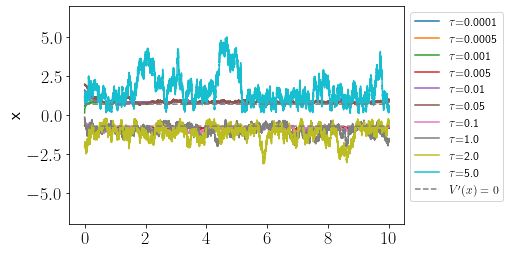

In [11]:
def run_num_plot(T,N,dt,s):
    """
    This function is similar to the one designed above but it is designed to work
    without numba and to produce samples examples of paths generated. 
    """
    y0 = np.random.normal(0,1,1)[0] #initial condition
    y_full = [y0]
    for ii in range(N*T):
        b1 = np.random.normal(0,1)
        y1 = e_m_fast(y0,s,b1,dt)
        y_full.append(y1)
        y0=y1
        
    return np.array(y_full)

run_num_plot(1,10,0.1,0.1)

# ---------- Generate samples path for different values of tau -------------

N=10**4 #Time discretisation
T=10 #Final time
t_list=np.arange(0,T+1/(N),1/(N)) #list of time discretise to plot 
dt = float(1/N)  #size of the time steps
tau_list = np.array([0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1,2,5]) #list of values of tau considered
for i in range(len(tau_list)): #loop through the different values of tau
    tau_i=tau_list[i] #get the value of tau
    s = np.sqrt(2*tau_i*dt) #get the related stochastic multiplicative term
    y_full=run_num_plot(T,N,dt,s) #value of X(T) as approximated by the numerical scheme
    plt.ylim(-7, 7) #zoom between -5 and 5 on the plot
    plt.plot(t_list,y_full,label="$\\tau$="+str(round(tau_i,5))) #plot the paths

plt.plot(t_list,np.ones(len(y_full))*(-1/np.sqrt(2)),"--",color="grey")
plt.plot(t_list,np.ones(len(y_full))*(1/np.sqrt(2)),"--",color="grey",label="$V'(x)=0$")    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# plt.title("Plot of example paths with different values of $\\tau $ ") #add the title
plt.ylabel("x")
    


We can see that the range of value for which we see a change of behaviours is between $10^{-3}$ and $ 5*10^{-2}$. In addition, the particles jumps the well, which they should not be able to do in reality. 

### Particles jumping well ? 
The particles jumps the well, which they should not be able to do in reality. Particles should never jump the well, it is an instability of the numerical method. This means the result is wrong.

Text(0.5, 1.0, 'Sample path examples with $\\tau=0.1$')

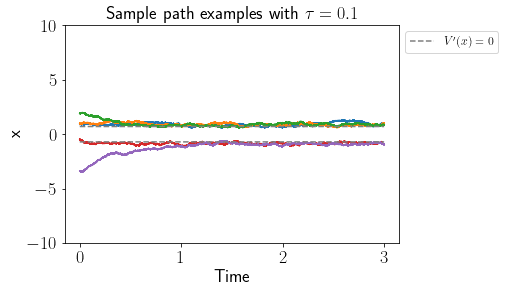

In [52]:
# ---------- Generate samples path for high value of tau -------------

N=10**6 #Time discretisation
T=3 #Final time
dt = float(1/N)  #size of the time steps

tau_i=0.1 #set a high value of tau to see the jump
n_samples = 5
for i in range(n_samples): #loop through the different values of tau
    s = np.sqrt(2*tau_i*dt) #get the related stochastic multiplicative term
    y_full=run_num_plot(T,N,dt,s) #value of X(T) as approximated by the numerical scheme
    t_list=np.arange(0,T+dt,dt)[0:len(y_full)] #list of time discretise to plot 
    plt.ylim(-10, 10) #zoom between -5 and 5 on the plot
    plt.plot(t_list,y_full) #,label="$path$="+str(round(tau_i,5))) #plot the paths

    
plt.plot(t_list,np.ones(len(y_full))*(-1/np.sqrt(2)),"--",color="grey",label="$V'(x)=0$")  
plt.plot(t_list,np.ones(len(y_full))*(1/np.sqrt(2)),"--",color="grey")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# plt.title("Plot of example paths with different values of $\\tau $ ") #add the title
plt.ylabel("x")
plt.xlabel("Time")
plt.title("Sample path examples with $\\tau=0.1$") 

Zooming out to see what the phenomenon looks like on a bigger scale: 


Text(0.5, 1.0, 'Sample path examples with $\\tau=0.1$')

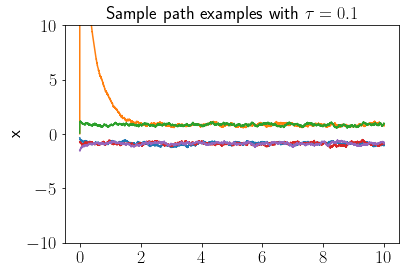

In [14]:

N=10**3 #Time discretisation
T=10 #Final time
t_list=np.arange(0,T+1/(N),1/(N)) #list of time discretise to plot 
dt = float(1/N)  #size of the time steps
tau_i=0.1 #set a high value of tau to see the jump
n_samples = 5
for i in range(n_samples): #loop through the different values of tau
    s = np.sqrt(2*tau_i*dt) #get the related stochastic multiplicative term
    y_full=run_num_plot(T,N,dt,s) #value of X(T) as approximated by the numerical scheme
    plt.ylim(-10, 10) #zoom between -5 and 5 on the plot
    plt.plot(t_list,y_full) #,label="$path$="+str(round(tau_i,5))) #plot the paths
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# plt.title("Plot of example paths with different values of $\\tau $ ") #add the title
plt.ylabel("x")
plt.title("Sample path examples with $\\tau=0.1$")


### Different values of $\tau$ and fixing $N=10^4$, $T_f=1$ and $n_{samples}=10^6$ and counting the number of escaping trajectories

Range of values for $\tau$ between [0.001,0.02]. try for different bound (characterisation of diverging trajectories). 

Below I redefined the code to add a parameter: bound. However, the code is very much slower when the parameter bound

In [19]:

# # define the gradV function 
# @njit(float64(float64))
# def dU(x):
#     """
#     Compute the potential of the infinite double well:
#     x: float 
#     """

#     return -1/(x*x*x)+2*x

# @njit(float64(float64,float64,float64,float64))
# def e_m_fast(y0,s,b1,dt):
#     """
#     The Euler-Maruyama scheme applied to the infinite double well
#     y0: float
#         value of y at t_n
#     tau: float
#         value of the temperature 
#     b1: float
#         brownian increment 
#     dt: float
#         time increment
#     """
#     y1=y0 - dU(y0)*dt+s*b1
#     return y1    
    
# @njit(float64(float64,float64,float64,float64))
# def run_num_sub(y0,s,dt,N):
    
#     for ii in range(N):
#         b1 = np.random.normal(0,1,1)[0]
#         y1 = e_m_fast(y0,s,b1,dt)
#         y0=y1 
#     return y0


# # @njit(nb.types.UniTuple(nb.float64,2)(float64,float64,float64,float64,float64))
# # def run_num(N,dt,s,T,n_esc):

# @njit(float64(float64,float64,float64,float64,float64))
# def run_num(bound,N,dt,s,T):
#     """
#     Run the simulation for one sample path
#     Input
#     -----
#     N: int
#         Number of steps taken in T=1 sec
#     dt: float 
#         Value of time increment. Is 1/N.
#     s: float 
#         Is sqrt(2 \tau). 
#     T: int
#         Final time
#     Return
#     ------
#     yf: float
#         Value of X(T) as approximated by the numerical scheme chosen
        
#     """
#     res=0
#     y0 = np.random.normal(0,1,1)[0]
#     for jj in range(T): # Run until T= Tsec
#         yf = run_num_sub(y0,s,dt,N)
#         if yf<-bound or yf>bound:
#             yf=99
#             break
#     return yf
# #, n_esc


# @njit(parallel=True)
# def DW_sde_fast(bound,n_samples,T,dt,tau): # Function is compiled and runs in machine code
#     """
#     Input
#     -------
#     n_samples: int
#         Number of sample to draw
#     T: int 
#         Final time
#     dt: int
#         Size of the time discretisation 
#     tau: float
#         Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
#     Return
#     -------
#     y_final: np.array
#         Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
#     """
#     N = int(np.round(1/dt,6))  #size of the time steps
#     y_final = [] #np.zeros(n_samples)
#     s = np.sqrt(2*tau*dt)
#     n_esc=0
#     for i in range(n_samples):
#         yf =run_num(bound,N,dt,s,T)
#         y_final.append(yf)
#     y_final=np.array(y_final)
#     return y_final

# y_compile = DW_sde_fast(10,1000,3,10,0.01) # compile the function

In [27]:
## --------------------- Try to get a plot with 
n_samples = 10**6
T=10
dt=0.5

tau_list = [0.001,0.005,0.01,0.05,0.1,0.5,1,2]
prop_list_b1=[]
for tau in tau_list:
    y = DW_sde_fast(n_samples,T,dt,tau)
    prop_y = prop_esc(y)
    prop_list_b1.append(prop_y)


In [28]:
## --------------------- Try to get a plot with 
n_samples = 10**6
T=10
dt=0.1

tau_list = [0.001,0.005,0.01,0.05,0.1,0.5,1,2]
prop_list_b2=[]
for tau in tau_list:
    y = DW_sde_fast(n_samples,T,dt,tau)
    prop_y = prop_esc(y)
    prop_list_b2.append(prop_y)

In [29]:
## --------------------- Try to get a plot with 
n_samples = 10**6
T=10
dt=0.25

tau_list = [0.001,0.005,0.01,0.05,0.1,0.5,1,2]
prop_list_b3=[]
for tau in tau_list:
    y = DW_sde_fast(n_samples,T,dt,tau)
    prop_y = prop_esc(y)
    prop_list_b3.append(prop_y)

In [30]:
## --------------------- Try to get a plot with 
n_samples = 10**6
T=10
dt=0.05

tau_list = [0.001,0.005,0.01,0.05,0.1,0.5,1,2]
prop_list_b4=[]
for tau in tau_list:
    y = DW_sde_fast(n_samples,T,dt,tau)
    prop_y = prop_esc(y)
    prop_list_b4.append(prop_y)

Text(0.5, 0, '$\\log(\\tau)$')

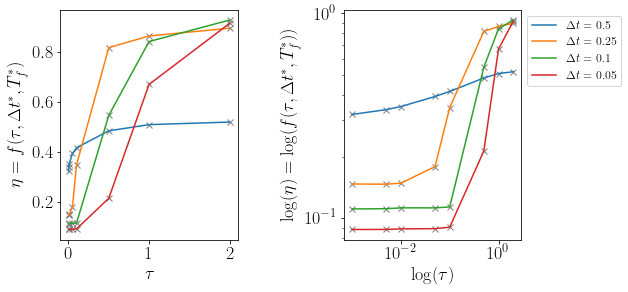

In [63]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.4)

ax1.plot(tau_list,prop_list_b1,"x",color="grey")
ax1.plot(tau_list,prop_list_b3,"x",color="grey")
ax1.plot(tau_list,prop_list_b2,"x",color="grey")
ax1.plot(tau_list,prop_list_b4,"x",color="grey")

ax1.plot(tau_list,prop_list_b1,label="$\\Delta t=0.5$")
ax1.plot(tau_list,prop_list_b3,label="$\\Delta t=0.25$")
ax1.plot(tau_list,prop_list_b2,label="$\\Delta t=0.1$")
ax1.plot(tau_list,prop_list_b4,label="$\\Delta t=0.05$")

ax1.set_ylabel("$\\eta=f(\\tau,\Delta t^*,T_f^*)$")
ax1.set_xlabel("$\\tau$")


ax2.loglog(tau_list,prop_list_b1,"x",color="grey")
ax2.loglog(tau_list,prop_list_b3,"x",color="grey")
ax2.loglog(tau_list,prop_list_b2,"x",color="grey")
ax2.loglog(tau_list,prop_list_b4,"x",color="grey")

ax2.loglog(tau_list,prop_list_b1,label="$\\Delta t=0.5$")
ax2.loglog(tau_list,prop_list_b3,label="$\\Delta t=0.25$")
ax2.loglog(tau_list,prop_list_b2,label="$\\Delta t=0.1$")
ax2.loglog(tau_list,prop_list_b4,label="$\\Delta t=0.05$")


ax2.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax2.set_ylabel("$\log(\\eta)=\log(f(\\tau,\Delta t^*,T_f^*))$")
ax2.set_xlabel("$\log(\\tau)$")


### Different values of $N$ and fixing $\tau=0.010$ , $T_f=1$ and $n_{samples}=10^3$  and counting the number of escaping trajectories

N= [10,50,100,500,1000,5000,10000]


In [84]:
dt_list=[0.3,0.1,0.03,0.01,0.003,0.001,0.0003,0.0001,0.00005]


In [ ]:
## --------------------- Try to get a plot with 
n_samples = 10**6
T=10
tau = 0.01
prop_list_diffdt1=[]
dt_list=[0.3,0.1,0.03,0.01,0.003,0.001,0.0003,0.0001,0.00005]

for jj in range(len(dt_list)):
    dti=dt_list[jj]
    y = DW_sde_fast(n_samples,T,dti,tau)
    prop_y = prop_esc(y)
    prop_list_diffdt1.append(prop_y)


In [ ]:
## --------------------- Try to get a plot with 
n_samples = 10**6
T=10
tau = 0.1
prop_list_diffdt2=[]
dt_list=[0.3,0.1,0.03,0.01,0.003,0.001,0.0003,0.0001,0.00005]

for jj in range(len(dt_list)):
    dti=dt_list[jj]
    y = DW_sde_fast(n_samples,T,dti,tau)
    prop_y = prop_esc(y)
    prop_list_diffdt2.append(prop_y)

In [ ]:
## --------------------- Try to get a plot with 
n_samples = 10**6
T=10
tau = 1
prop_list_diffdt3=[]
dt_list=[0.3,0.1,0.03,0.01,0.003,0.001,0.0003,0.0001,0.00005]

for jj in range(len(dt_list)):
    dti=dt_list[jj]
    y = DW_sde_fast(n_samples,T,dti,tau)
    prop_y = prop_esc(y)
    prop_list_diffdt3.append(prop_y)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.4)

ax1.plot(dt_list,prop_list_diffdt1,"x",color="grey")
ax1.plot(dt_list,prop_list_diffdt1,label="$\\tau t=0.01$")
ax1.plot(dt_list,prop_list_diffdt2,"x",color="grey")
ax1.plot(dt_list,prop_list_diffdt2,label="$\\tau=0.1$")
ax1.plot(dt_list,prop_list_diffdt3,"x",color="grey")
ax1.plot(dt_list,prop_list_diffdt3,label="$\\tau=1$")


ax1.set_ylabel("$\\eta=f(\\tau^*,\Delta t,T_f^*)$")
ax1.set_xlabel("$\\Delta t$")


ax2.loglog(dt_list,prop_list_diffdt1,"x",color="grey")
ax2.loglog(dt_list,prop_list_diffdt1,label="$\\tau=0.01$")
ax2.loglog(dt_list,prop_list_diffdt2,"x",color="grey")
ax2.loglog(dt_list,prop_list_diffdt2,label="$\\tau=0.1$")
ax2.loglog(dt_list,prop_list_diffdt3,"x",color="grey")
ax2.loglog(dt_list,prop_list_diffdt3,label="$\\tau=1$")

ax2.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax2.set_ylabel("$\log(\\eta)=\log(f(\\tau^*,\Delta t,T_f^*))$")
ax2.set_xlabel("$\log(\\Delta t)$")




### Different values of $T_f$ and fixing $\tau=0.010$ , $T_f=1$ and $n_{samples}=10^3$  and counting the number of escaping trajectories


In [93]:
## --------------------- Try to get a plot with 
n_samples = 10**6
tau = 0.01
dt=0.1
prop_list_diffT0=[]
T_list=[0.2,0.5,1,2,5,10]
for jj in range(len(T_list)):
    Ti=T_list[jj]
    y = DW_sde_fast(n_samples,Ti,dt,tau)
    prop_y = prop_esc(y)
    prop_list_diffT0.append(prop_y)

In [80]:
## --------------------- Try to get a plot with 
n_samples = 10**6
tau = 0.1
dt=0.1
prop_list_diffT1=[]
T_list=[0.2,0.5,1,2,5,10]
for jj in range(len(T_list)):
    Ti=T_list[jj]
    y = DW_sde_fast(n_samples,Ti,dt,tau)
    prop_y = prop_esc(y)
    prop_list_diffT1.append(prop_y)

In [101]:
## --------------------- Try to get a plot with 
n_samples = 10**6
tau = 0.5
dt=0.1
prop_list_diffT1a=[]
T_list=[0.2,0.5,1,2,5,10]
for jj in range(len(T_list)):
    Ti=T_list[jj]
    y = DW_sde_fast(n_samples,Ti,dt,tau)
    prop_y = prop_esc(y)
    prop_list_diffT1a.append(prop_y)

In [113]:
## --------------------- Try to get a plot with 
n_samples = 10**6
tau = 1
dt=0.1
prop_list_diffT2=[]
T_list=[0.2,0.5,1,2,5,10]
for jj in range(len(T_list)):
    Ti=T_list[jj]
    y = DW_sde_fast(n_samples,Ti,dt,tau)
    prop_y = prop_esc(y)
    prop_list_diffT2.append(prop_y)

In [111]:
## --------------------- Try to get a plot with 
n_samples = 10**6
tau = 0.1
prop_list_diffT3=[]
T_list=[0.2,0.5,1,2,5,10]
dt=0.01
for jj in range(len(T_list)):
    Ti=T_list[jj]
    y = DW_sde_fast(n_samples,Ti,dt,tau)
    prop_y = prop_esc(y)
    prop_list_diffT3.append(prop_y)

In [112]:
## --------------------- Try to get a plot with 
n_samples = 10**6
tau = 0.1
prop_list_diffT4=[]
T_list=[0.2,0.5,1,2,5,10]
dt=0.2
for jj in range(len(T_list)):
    Ti=T_list[jj]
    y = DW_sde_fast(n_samples,Ti,dt,tau)
    prop_y = prop_esc(y)
    prop_list_diffT4.append(prop_y)

Text(0.5, 0, '$\\log(T_f)$')

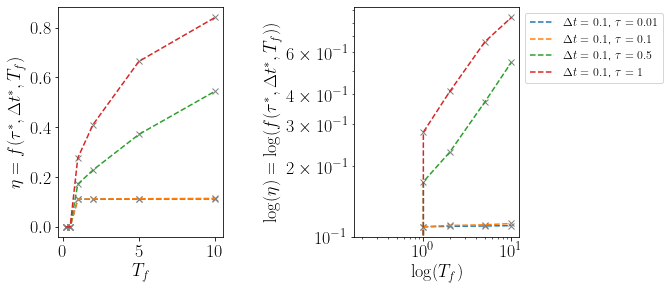

In [106]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)

ax1.plot(T_list,prop_list_diffT0,"x",color="grey")
ax1.plot(T_list,prop_list_diffT0,"--",label="$\\tau=0.01$,$\Delta t =0.1$")
ax1.plot(T_list,prop_list_diffT1,"x",color="grey")
ax1.plot(T_list,prop_list_diffT1,"--",label="$\\tau=0.1$ $\Delta t =0.1$")
ax1.plot(T_list,prop_list_diffT1a,"x",color="grey")
ax1.plot(T_list,prop_list_diffT1a,"--",label="$\\tau=0.5$ $\Delta t =0.1$")
ax1.plot(T_list,prop_list_diffT2,"x",color="grey")
ax1.plot(T_list,prop_list_diffT2,"--",label="$\\tau=1$, $\\Delta t=0.1$")


ax1.set_ylabel("$\\eta=f(\\tau^*,\Delta t^*,T_f)$")
ax1.set_xlabel("$T_f$")


ax2.loglog(T_list,prop_list_diffT0,"x",color="grey")
ax2.loglog(T_list,prop_list_diffT0,"--",label="$\Delta t =0.1$, $\\tau=0.01$")
ax2.loglog(T_list,prop_list_diffT1,"x",color="grey")
ax2.loglog(T_list,prop_list_diffT1,"--",label="$\Delta t =0.1$, $\\tau=0.1$")
ax2.loglog(T_list,prop_list_diffT1a,"x",color="grey")
ax2.loglog(T_list,prop_list_diffT1a,"--",label="$\Delta t =0.1$, $\\tau=0.5$")
ax2.loglog(T_list,prop_list_diffT2,"x",color="grey")
ax2.loglog(T_list,prop_list_diffT2,"--",label="$\\Delta t=0.1$, $\\tau=1$")



ax2.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax2.set_ylabel("$\log(\\eta)=\log(f(\\tau^*,\Delta t^*,T_f))$")
ax2.set_xlabel("$\log(T_f)$")



Text(0.5, 0, '$\\log(T_f)$')

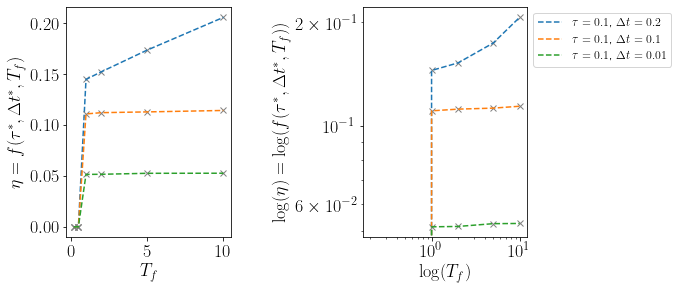

In [114]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)

ax1.plot(T_list,prop_list_diffT4,"x",color="grey")
ax1.plot(T_list,prop_list_diffT4,"--",label="$\\tau=0.1$, $\Delta t =0.2$")
ax1.plot(T_list,prop_list_diffT1,"x",color="grey")
ax1.plot(T_list,prop_list_diffT1,"--",label="$\\tau=0.1$, $\Delta t =0.1$")
ax1.plot(T_list,prop_list_diffT3,"x",color="grey")
ax1.plot(T_list,prop_list_diffT3,"--",label=" $\\tau=0.1$, $\Delta t =0.01$")


ax1.set_ylabel("$\\eta=f(\\tau^*,\Delta t^*,T_f)$")
ax1.set_xlabel("$T_f$")


ax2.loglog(T_list,prop_list_diffT4,"x",color="grey")
ax2.loglog(T_list,prop_list_diffT4,"--",label=" $\\tau=0.1$, $\Delta t =0.2$")
ax2.loglog(T_list,prop_list_diffT1,"x",color="grey")
ax2.loglog(T_list,prop_list_diffT1,"--",label=" $\\tau=0.1$, $\Delta t =0.1$")
ax2.loglog(T_list,prop_list_diffT3,"x",color="grey")
ax2.loglog(T_list,prop_list_diffT3,"--",label=" $\\tau=0.1$, $\Delta t =0.01$")




ax2.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax2.set_ylabel("$\log(\\eta)=\log(f(\\tau^*,\Delta t^*,T_f))$")
ax2.set_xlabel("$\log(T_f)$")



### Analysing a trajectory